内容包括：

一.数据处理：

1.导入，索引，基本统计分析

2.频率重采样

3.数据分布

4.数据异常值处理

二、数据特征：

1.Talib库介绍

2.数据特征构建

3.特征缩放和变换

4.特征相关性分析

5.特征重要性分析

                      Open   High    Low  Close  Volume        Std  \
datetime                                                             
2014-05-05 09:05:00  14285  14325  14200  14305   47436        NaN   
2014-05-05 09:10:00  14305  14470  14280  14375   46548        NaN   
2014-05-05 09:15:00  14370  14415  14360  14410   18904        NaN   
2014-05-05 09:20:00  14410  14430  14385  14400   14594        NaN   
2014-05-05 09:25:00  14405  14405  14380  14385    7664        NaN   
2014-05-05 09:30:00  14380  14410  14365  14400    9120        NaN   
2014-05-05 09:35:00  14400  14400  14360  14375   10452        NaN   
2014-05-05 09:40:00  14375  14395  14370  14395    5744        NaN   
2014-05-05 09:45:00  14395  14415  14380  14405    8704        NaN   
2014-05-05 09:50:00  14410  14415  14370  14385   11302        NaN   
2014-05-05 09:55:00  14380  14395  14360  14380    9264        NaN   
2014-05-05 10:00:00  14385  14395  14365  14390    7938        NaN   
2014-05-05 10:05:00 

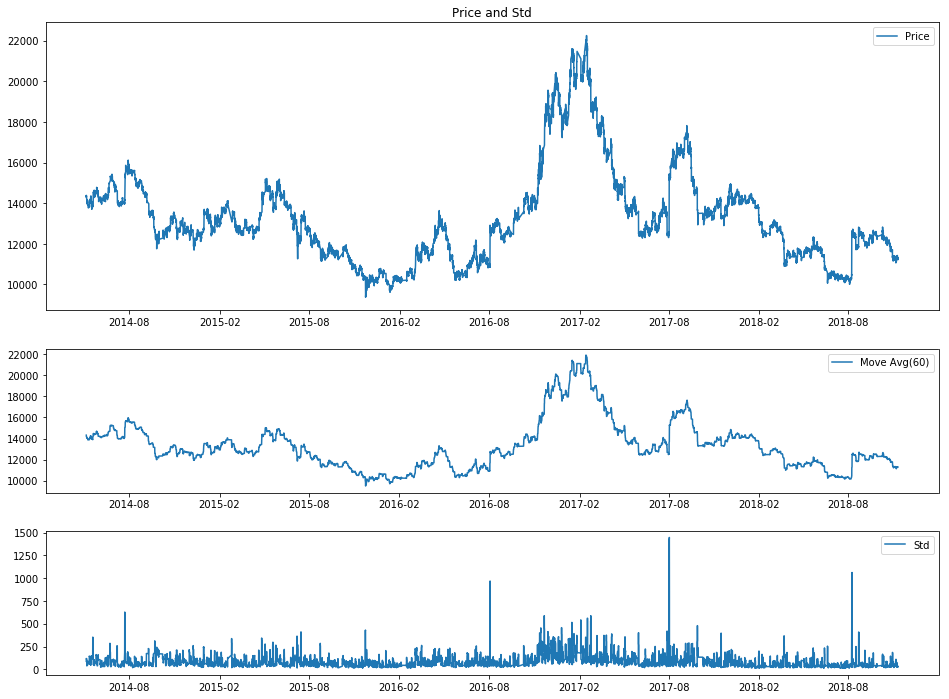

In [26]:
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
from matplotlib import gridspec

#获取数据，设置索引
def get_data(filename):
    data=pd.read_excel(filename)
    data['datetime']=pd.to_datetime(data['datetime'])
    data=data.set_index('datetime')
    return data

#基本统计函数
def basic_stats(data,featname,win):
    std =data[featname].rolling(win).std()
    mean=data[featname].rolling(win).mean()
    return std,mean
    
#画图
def plot_pic(data):
    gs1 = gridspec.GridSpec(3,1,height_ratios=[2,1,1])
    plt.figure(figsize=[16,12])
    ax1 = plt.subplot(gs1[0])
    plt.plot(data['Close'], label='Price')
    handles1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(handles1, labels1)
    #打印抬头
    plt.title('Price and Std')

    ax2 = plt.subplot(gs1[1])
    plt.plot(data['MA'], label='Move Avg(60)')
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles2, labels2)

    ax3 = plt.subplot(gs1[2])
    plt.plot(data['Std'], label='Std')
    handles3, labels3 = ax3.get_legend_handles_labels()
    ax3.legend(handles3, labels3)
    
    
filename='C:\\HiData\\Users\\ShenHong\\合作\\融秀\\AI量化初级\\notebook\\SHFE_ru_HOT_5.xlsx'
data=get_data(filename)
std,mean=basic_stats(data,'Close',60)
data['Std']=std
data['MA']=mean
print(data)
plot_pic(data)

<h1>时间序列分析</h1>
时间序列分析（time series analysis）是量化投资中的一门基本技术，时间序列是指在一定时间内按

时间顺序测量的某个变量的取值序列。比如变量是股票价格，那么它随时间的变化就是一个时间序列；

同样的，如果变量是股票的收益率，则它随时间的变化也是一个时间序列。时间序列分析就是使用统计

的手段对这个序列的过去进行分析，以此对该变量的变化特性建模、并对未来进行预测。时间序列分析

试图通过研究过去来预测未来。在量化投资领域，我们的目标是通过统计手段对投资品的收益率这个时间

序列建模，以此推断序列中不同交易日的收益率之间有无任何特征，以此来预测未来的收益率并产生交易

信号。


<h2>一个时间序列可能存在的特征包括以下几种：</h2>

1.趋势：趋势是时间序列在某一方向上持续运动（比如牛市时股市每天都在上涨，股票收益率持续为正；

熊市时股市每天都在下跌，股票收益率持续为负）。趋势经常出现在金融时间序列中，特别是大宗商品

价格。


2.季节变化：许多时间序列中包含季节变化。在金融领域，我们经常看到商品价格的季节性变化，特别是

那些与生长季节或温度变化有关的商品，比如天然气。


3.序列相关性：金融时间序列的一个最重要特征是序列相关性（serial correlation），又称为自相关性

（autocorrelation）。以投资品的收益率序列为例，我们会经常观察到一段时间内的收益率之间存在正

相关或者负相关。


4.随机噪声：它是时间序列中除去趋势、季节变化和自相关性之后的剩余随机扰动。由于时间序列存在不

确定性，随机噪声总是夹杂在时间序列中，致使时间序列表现出某种震荡式的无规律运动。

<h2>下图分析平稳序列和非平稳序列差异：</h2>

下图分析了平稳序列和非平稳序列的差异，对于平稳序列均值和方差是固定的，不是时间的函数，因此未来

是可以预测的，而非平稳序列则相反，均值和方差随着时间变化。

![](https://github.com/shgefu/AI_Quant_Course/tree/master/notebook/timeseries.jpg "平稳序列与非平稳序列")


<h2>下面的代码用收益率序列，画出了收益率序列本身，其自相关性和正太性。

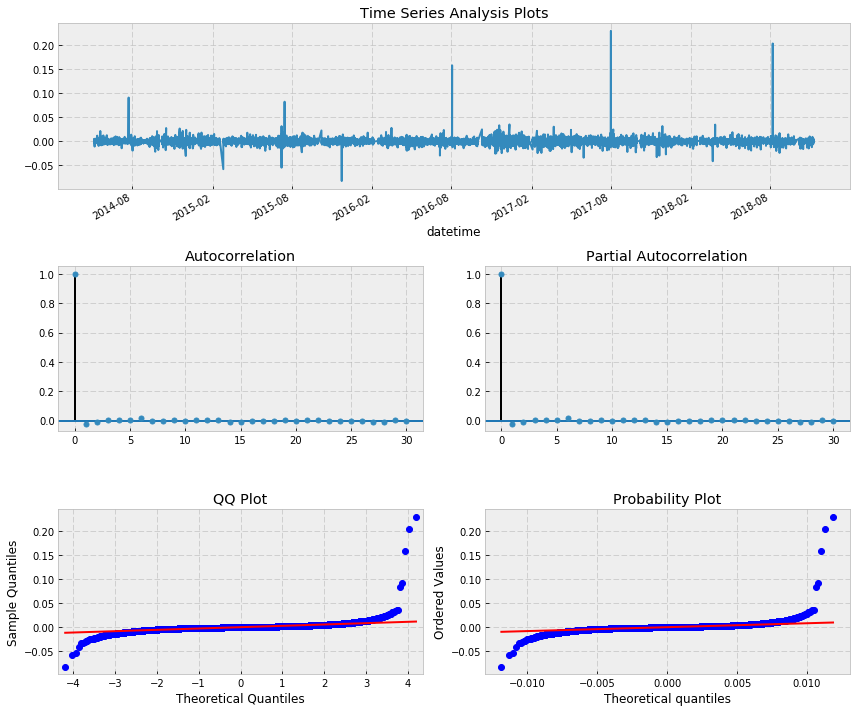

In [23]:
#时间序列分析画图函数
def tsplot(y, lags=None, figsize=(12, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

#对收益率序列进行时间序列相关性、正太性分析
returns=data['Close']/data['Close'].shift(1) - 1.0
returns=returns.fillna(method='bfill')
tsplot(returns,lags=30)

所谓频率重采样，指的是如果我们只有频率较高的数据，想要得到频率较低的数据，那么我们可以采用高频数据聚合的方式得到低频数据集。

比如，我们只有5分钟数据，但是我们想得到日频数据，就需要频率重采样函数。Pandas包提供了一套方法实现此功能，可以很方便地从高频数据得到低频数据。

               Open     High      Low    Close  Volume         Std       MA
datetime                                                                   
2014-05-09  13950.0  13975.0  13755.0  13770.0  643906  222.794749  14045.0
2014-05-16  14045.0  14080.0  13635.0  13820.0  722082  174.699742  14087.0
2014-05-23  14450.0  14640.0  14310.0  14440.0  770142  102.627969  14428.0
2014-05-30  14275.0  14355.0  14070.0  14125.0  623690  232.039867  14434.0
2014-06-13  14050.0  14500.0  14045.0  14390.0  721820  108.742816  14275.0
2014-06-20  14590.0  15020.0  14540.0  14965.0  775554  288.496100  14484.0
2014-06-27  15335.0  15335.0  15060.0  15140.0  420976   84.602009  15262.0
2014-07-04  14790.0  14865.0  14590.0  14645.0  434826   93.768332  14799.0
2014-07-11  13970.0  14045.0  13805.0  13905.0  356734   44.944410  13963.0
2014-07-18  14275.0  14305.0  14050.0  14065.0  260254   97.301079  14069.0
2014-07-25  15690.0  15765.0  15550.0  15715.0  442964  851.363612  15017.0
2014-08-01  

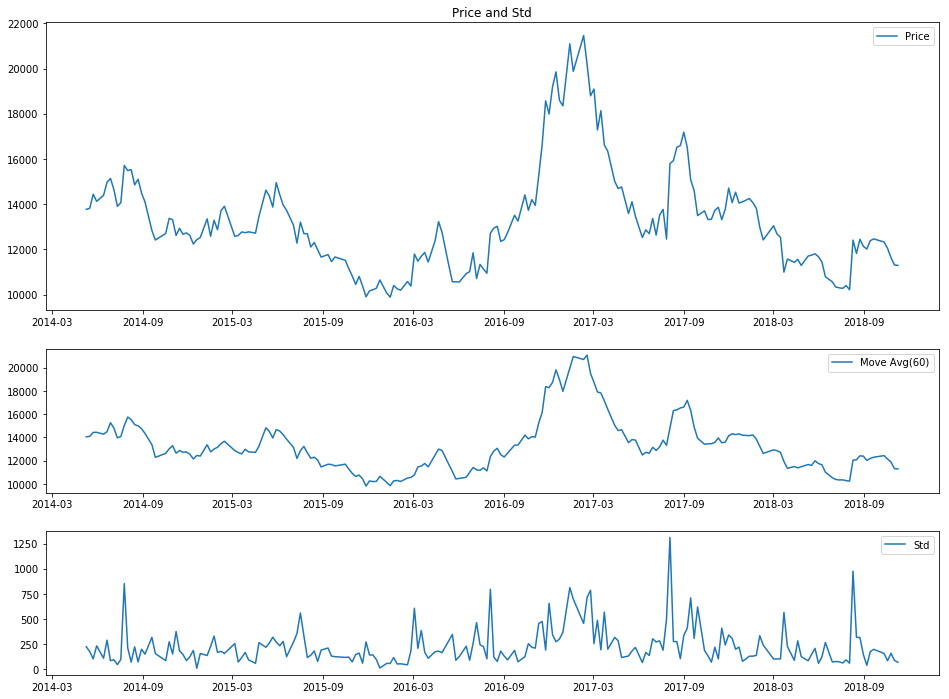

In [47]:
#高频数据汇总成低频数据，通过resample函数重采样，ohlc()函数生成指定列的open,high,low,close四个汇总字段
def high_2_Low(tmp, freq):
    """
    tmp:含Open,High,Low,Close,Volume字段的数据
    freq:目标频率：
    """
    # 分别处理bar数据
    tmp_open = tmp['Open'].resample(freq).ohlc()
    tmp_open = tmp_open['open'].dropna()

    tmp_high = tmp['High'].resample(freq).ohlc()
    tmp_high = tmp_high['high'].dropna()

    tmp_low = tmp['Low'].resample(freq).ohlc()
    tmp_low = tmp_low['low'].dropna()

    tmp_close = tmp['Close'].resample(freq).ohlc()
    tmp_close = tmp_close['close'].dropna()

    tmp_price = pd.concat([tmp_open, tmp_high, tmp_low, tmp_close], axis=1)

    # 处理成交量
    tmp_volume = tmp['Volume'].resample(freq).sum()
    tmp_volume.dropna(inplace=True)
    
    res= pd.concat([tmp_price, tmp_volume], axis=1)
    res=res[['open','high','low','close','Volume']]
    res.columns=['Open','High','Low','Close','Volume']
    return res

data_day=high_2_Low(data,'1d')
day_std,day_mean=basic_stats(data_day,'Close',5)
data_day['Std']=day_std
data_day['MA']=day_mean
data_day=data_day.dropna(how='any')  #去掉非交易日
print(data_day)
plot_pic(data_day)

在构建量化程序时，经常需要看某个序列的分布，比如收益率的分布情况，预测概率的分布情况，从而给策略创建和优化提供依据

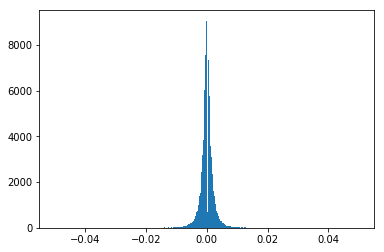

In [57]:
#查看序列的分布情况，可以看到大部分收益率接近0，收益率基本呈现正态分布
returns=data.Close/data.Close.shift(1) - 1.0  #5分钟bar的收益率
returns.dropna(how='any',inplace=True)
_ = plt.hist(returns.values,bins=300,range=[-0.05,0.05])

In [58]:
#检验序列是否符合正太分布
